<a href="https://colab.research.google.com/github/glucard/Leaves-dataset/blob/main/YOLO_pipeline_v2_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training YOLO

In [1]:
train = True

In [2]:
yolo_names = ['Apple', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Orange', 'Peach', 'Pepper', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']

### Config

In [3]:
!nvidia-smi

Wed May 24 06:12:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [5]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.107 🚀 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.3/78.2 GB disk)


In [6]:
from ultralytics import YOLO

from IPython.display import display, Image, clear_output

### Preparing dataset

In [7]:
!wget -O repo.zip https://github.com/glucard/Leaves-dataset/archive/refs/heads/disease-dataset.zip
!unzip repo.zip -d repo
!mv "/content/repo/Leaves-dataset-disease-dataset/data/Disease-dataset/leaf-boxes/" "/content/datasets"

clear_output()

In [8]:
%%writefile custom.yaml
train: train
val: val

nc: 14

names: ['Apple', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Orange', 'Peach', 'Pepper', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato',
]

Writing custom.yaml


### Training

In [ ]:
%cd {HOME}
if train:
  !yolo task=detect mode=train model=yolov8n.pt data=custom.yaml epochs=80 imgsz=640

In [10]:
if train:
  yolo_model = YOLO('/content/runs/detect/train/weights/best.pt')
else:
  yolo_model = YOLO('/content/repo/Leaves-dataset-disease-dataset/models/yolo_leafs_v1.pt')
pred = yolo_model.predict(
   source='/content/datasets/train/images/031a184f-Apple___healthy_image_1127.JPG',
   conf=0.25
)


image 1/1 /content/datasets/train/images/031a184f-Apple___healthy_image_1127.JPG: 640x640 1 Apple, 9.2ms
Speed: 4.2ms preprocess, 9.2ms inference, 11.3ms postprocess per image at shape (1, 3, 640, 640)


In [11]:
pred[0].boxes.data

tensor([[ 48.5283,  19.0965, 456.2009, 462.7732,   0.9572,   0.0000]], device='cuda:0')

### Report

In [13]:
train_folder_path = "/content/runs/detect/train"

import os
import cv2

if train:
  images_names = [[f, os.path.join(train_folder_path, f)] for f in os.listdir(train_folder_path) if f.split('.')[-1] in ['jpg', 'png']]

  images = [cv2.imread(img[1]) for img in images_names]

train_batch2.jpg


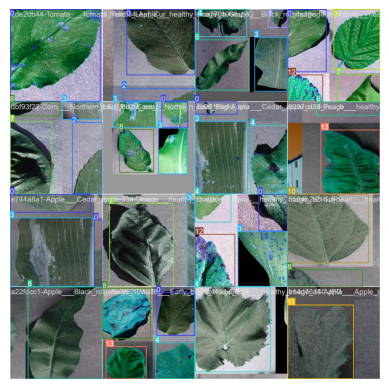



train_batch1.jpg


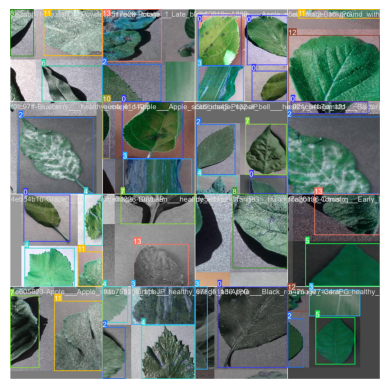



results.png


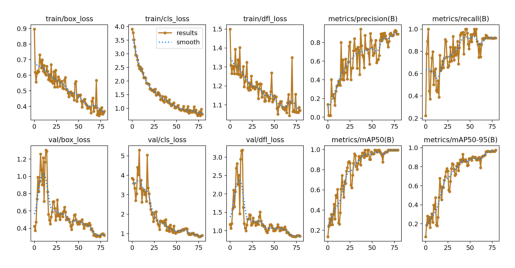



confusion_matrix_normalized.png


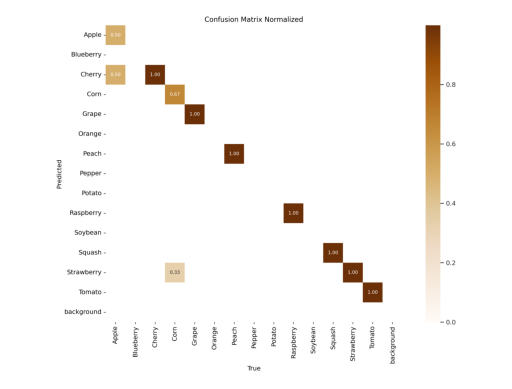



R_curve.png


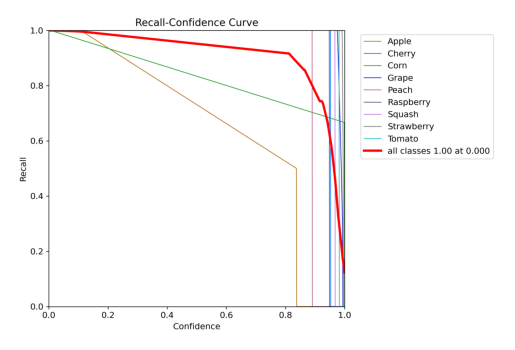



P_curve.png


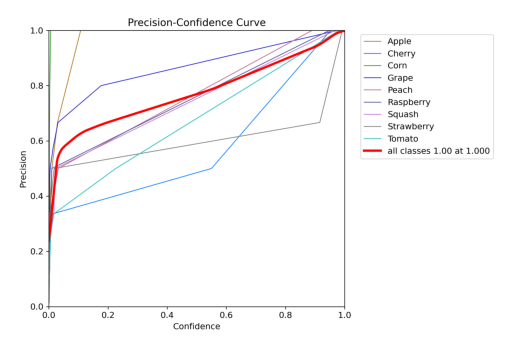



val_batch0_pred.jpg


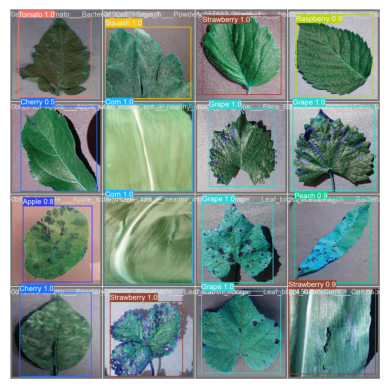



labels_correlogram.jpg


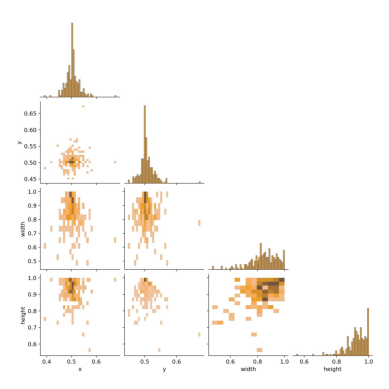



labels.jpg


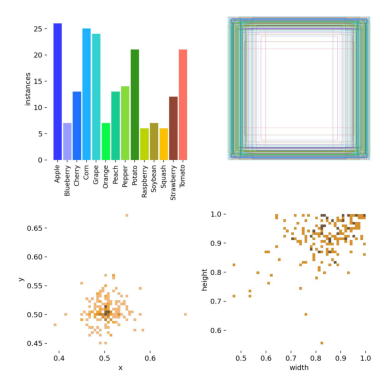



confusion_matrix.png


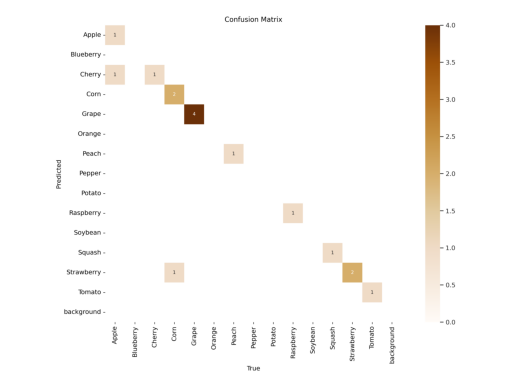



val_batch0_labels.jpg


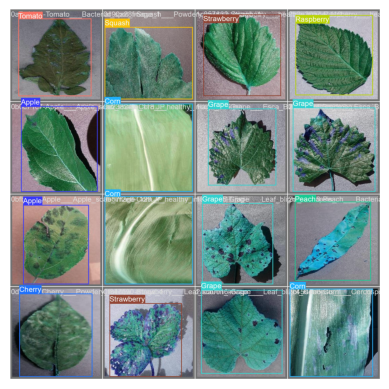



train_batch0.jpg


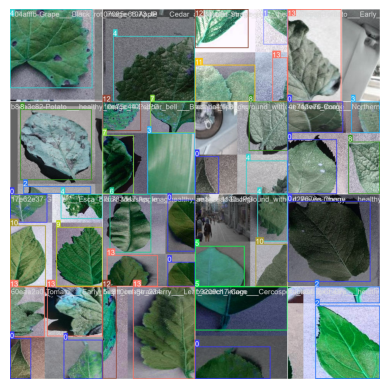



F1_curve.png


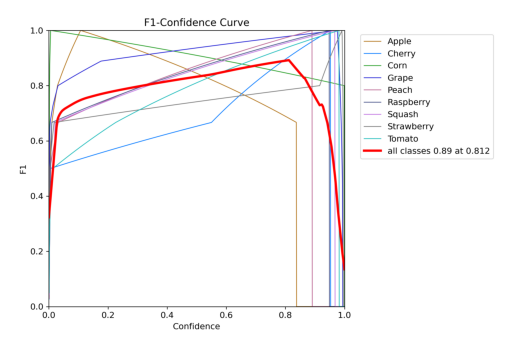



PR_curve.png


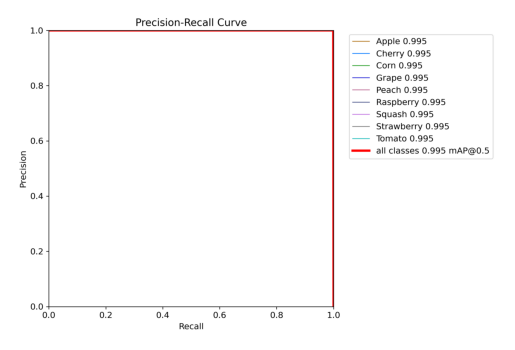

In [14]:
from matplotlib import pyplot as plt

if train:
  for img, names in zip(images, images_names):
    print(names[0])
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    print('\n')

## Training disease classifier

### Setting up DatasetManager

In [15]:
import numpy as np
import os
import tensorflow as tf

In [16]:
BATCH_SIZE = 30
IMG_SIZE = (299, 299)

AUTOTUNE = tf.data.AUTOTUNE

def image_standardization(image):
      image = tf.math.subtract(image, tf.math.reduce_mean(image))
      return image

class DatasetManager:
  def load_dataset(path):

    leaves_dataset = tf.keras.utils.image_dataset_from_directory(
        path,
        shuffle=True,
        batch_size=BATCH_SIZE,
        color_mode='rgb',
        image_size=IMG_SIZE,
        crop_to_aspect_ratio=False,
    )
    return leaves_dataset

  def split_train_val(dataset, train_size):
    """
    Params:
      dataset (BatchDataset): the dataset.
      train_size (float): float number between 0 and 1.
    
    Return
      train_dataset, val_dataset
    """

    dataset_length = dataset.cardinality().numpy()
    dataset_slice = int(dataset_length * train_size)
    train_dataset = dataset.take(dataset_slice)
    val_dataset = dataset.skip(dataset_slice)

    return train_dataset, val_dataset

  def norm_dataset(dataset):
    def map_image_standardization(image, label):
      """image = tf.image.per_image_standardization(image)"""
      image = map_image_standardization(image)
      return image, label

    return dataset.map(image_standardization)
  #train_dataset, val_dataset = norm_dataset(train_dataset), norm_dataset(val_dataset)

  def get_class_names(dataset):
    return dataset.class_names

  
  def autotune(dataset):
    return dataset.prefetch(buffer_size=AUTOTUNE)

  """
  val_batches = tf.data.experimental.cardinality(validation_dataset) # lenght dataset
  test_dataset = validation_dataset.take(val_batches // 2) # lenght//5 first elements in test_dataset
  # validation_dataset = validation_dataset.skip(val_batches // 2) # skipping elements used in test_dataset

  print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
  print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
  """

In [17]:


"""
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
"""

'\ntrain_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)\nvalidation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)\ntest_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)\n'

In [18]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(244, 244),
  tf.keras.layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation((-0.2, 0.3)),
])

In [19]:
preprocess_input = tf.keras.applications.xception.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### Setting up Transfer Learning

#### Importing model

In [20]:
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

(299, 299, 3)
83683744/83683744 [==============================] - 1s 0us/step


In [21]:
def get_feature_batch(dataset):
  image_batch, label_batch = next(iter(dataset)) # next(iter()) parece uma fila.
  feature_batch = base_model(image_batch)
  return feature_batch

In [22]:
def get_prediction_layer(classes_length, dataset):
  prediction_layer = tf.keras.layers.Dense(classes_length, activation='softmax',
                                         kernel_regularizer=tf.keras.regularizers.L1(1e-3),
                                         activity_regularizer=tf.keras.regularizers.L2(1e-2))
  feature_batch = get_feature_batch(dataset)

  average_batch = global_average_layer(feature_batch)
  prediction_batch = prediction_layer(average_batch)

  #print(prediction_batch.shape)

  return prediction_layer


In [23]:
LR = 0.0007

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)

x = global_average_layer(x)
# x = hidden_layer_0(x)

def get_model(prediction_layer):
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [24]:
from sklearn.metrics import classification_report

def evaluate_model(model, dataset, class_names):
  for images, labels in dataset.unbatch().batch(616).take(1):
    y_pred = np.argmax(model.predict(images), axis=1)
    print(classification_report(labels.numpy(), y_pred, target_names=class_names))

### Training models

In [25]:
!mv "/content/repo/Leaves-dataset-disease-dataset/data/Disease-dataset/yolo_preprocessed-disease-by_leaf" "/content/diseases_by_leaf"
PATH = '/content/diseases_by_leaf'


In [26]:
from collections import defaultdict

disease_models = defaultdict(lambda: defaultdict(dict))

diseases_by_leafs = (name for name in os.listdir(PATH))
for dataset_name in diseases_by_leafs:
  dataset_path = os.path.join(PATH, dataset_name)
  dataset = DatasetManager.load_dataset(dataset_path)
  dataset_class_names = dataset.class_names
  class_length = len(dataset.class_names)
  
  initial_epochs = 1
  if class_length != 1:
    initial_epochs = class_length * 4

  # dataset = DatasetManager.norm_dataset(dataset)

  train_dataset, val_dataset = DatasetManager.split_train_val(dataset, 0.75)
  val_dataset, test_dataset = DatasetManager.split_train_val(dataset, 0.5)

  train_dataset, val_dataset = DatasetManager.autotune(train_dataset), DatasetManager.autotune(val_dataset)

  prediction_layer = get_prediction_layer(class_length, dataset)

  model = get_model(prediction_layer)

  history = model.fit(train_dataset,
                      epochs=initial_epochs,
                      validation_data=val_dataset)
  
  disease_models[dataset_name]['model'] = model
  disease_models[dataset_name]['class_names'] = dataset_class_names
  disease_models[dataset_name]['test_dataset'] = test_dataset
  disease_models[dataset_name]['train_history'] = history




Found 47 files belonging to 1 classes.


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 [==============================] - 9s 9s/step - loss: 0.0649 - accuracy: 0.0000e+00 - val_loss: 0.0635 - val_accuracy: 0.0000e+00
Found 102 files belonging to 2 classes.
Epoch 1/8
3/3 [==============================] - 6s 1s/step - loss: 0.8422 - accuracy: 0.5333 - val_loss: 0.7724 - val_accuracy: 0.6500
Epoch 2/8
3/3 [==============================] - 2s 625ms/step - loss: 0.7692 - accuracy: 0.6111 - val_loss: 0.7377 - val_accuracy: 0.7667
Epoch 3/8
3/3 [==============================] - 2s 606ms/step - loss: 0.7338 - accuracy: 0.7556 - val_loss: 0.7142 - val_accuracy: 0.7833
Epoch 4/8
3/3 [==============================] - 2s 617ms/step - loss: 0.7223 - accuracy: 0.7444 - val_loss: 0.7072 - val_accuracy: 0.7500
Epoch 5/8
3/3 [==============================] - 2s 612ms/step - loss: 0.6883 - accuracy: 0.8111 - val_loss: 0.6573 - val_accuracy: 0.8000
Epoch 6/8
3/3 [==============================] - 2s 610ms/step - loss: 0.6663 - accuracy: 0.7889 - val_loss: 0.6768 - val_accuracy: 0.

In [27]:

diseases_by_leafs = (name for name in os.listdir(PATH))
for dataset_name in diseases_by_leafs:
  model = disease_models[dataset_name]['model']
  test_dataset = disease_models[dataset_name]['test_dataset']
  class_names = disease_models[dataset_name]['class_names']

  print(f"{'-'*50}\n: {'-'*20}{dataset_name}{'-'*20}\n {'-'*50}")
  evaluate_model(model, test_dataset, class_names)
  print('_'*50+'\n')

--------------------------------------------------
: --------------------Raspberry--------------------
 --------------------------------------------------
1/1 [==============================] - 3s 3s/step
              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00        17

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17

__________________________________________________

--------------------------------------------------
: --------------------Pepper--------------------
 --------------------------------------------------
2/2 [==============================] - 6s 1s/step
                precision    recall  f1-score   support

Bacterial_spot       1.00      0.55      0.71        20
       healthy       0.71      1.00      0.83        22

      accuracy                           0.79        42
     macro avg       0.85      0.78      0

1/1 [==============================] - 2s 2s/step
              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00        21

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

__________________________________________________

--------------------------------------------------
: --------------------Peach--------------------
 --------------------------------------------------


2/2 [==============================] - 1s 223ms/step
                precision    recall  f1-score   support

Bacterial_spot       0.95      1.00      0.97        19
       healthy       1.00      0.95      0.98        22

      accuracy                           0.98        41
     macro avg       0.97      0.98      0.98        41
  weighted avg       0.98      0.98      0.98        41

__________________________________________________

--------------------------------------------------
: --------------------Blueberry--------------------
 --------------------------------------------------
1/1 [==============================] - 1s 931ms/step
              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00        21

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

__________________________________________________

-----------------------

### Evaluating model

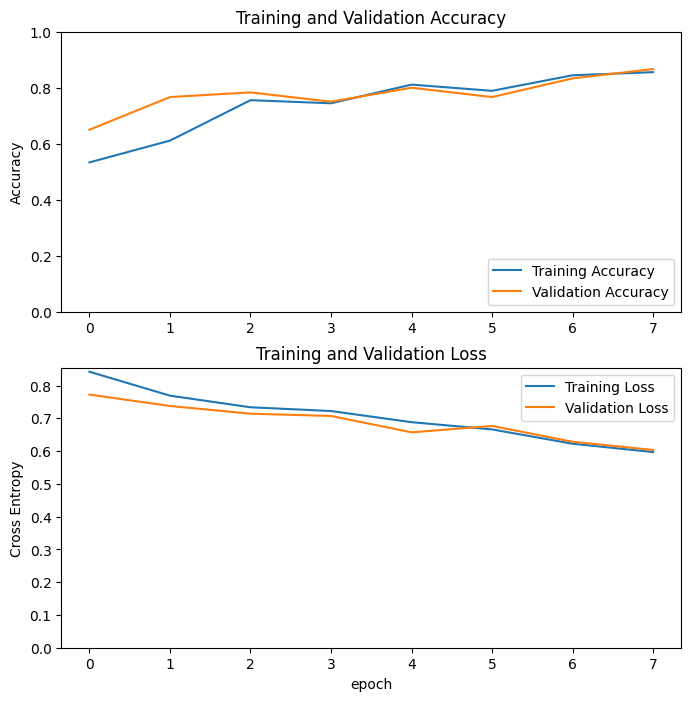

Pepper



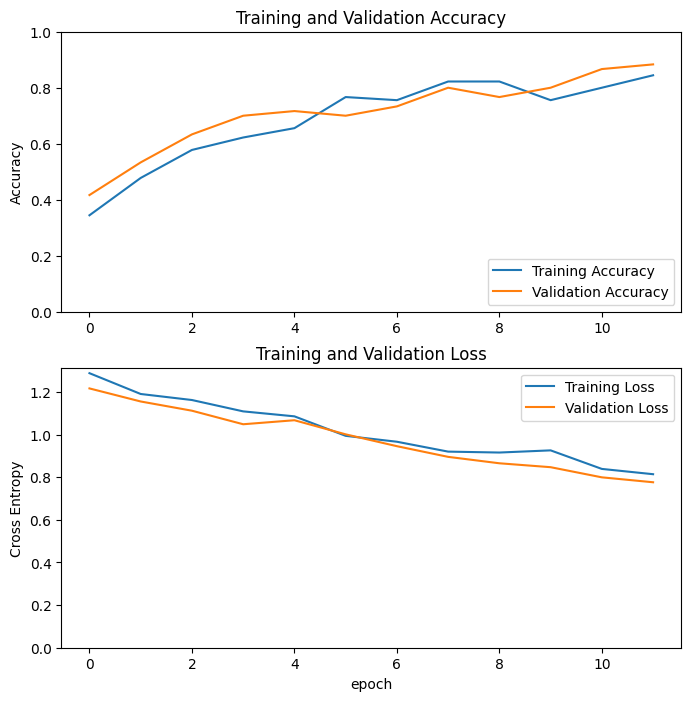

Potato



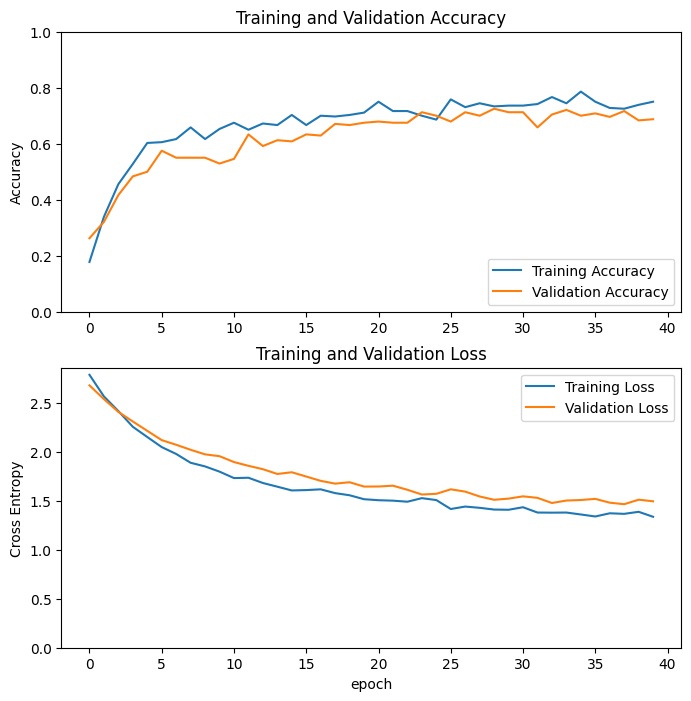

Tomato



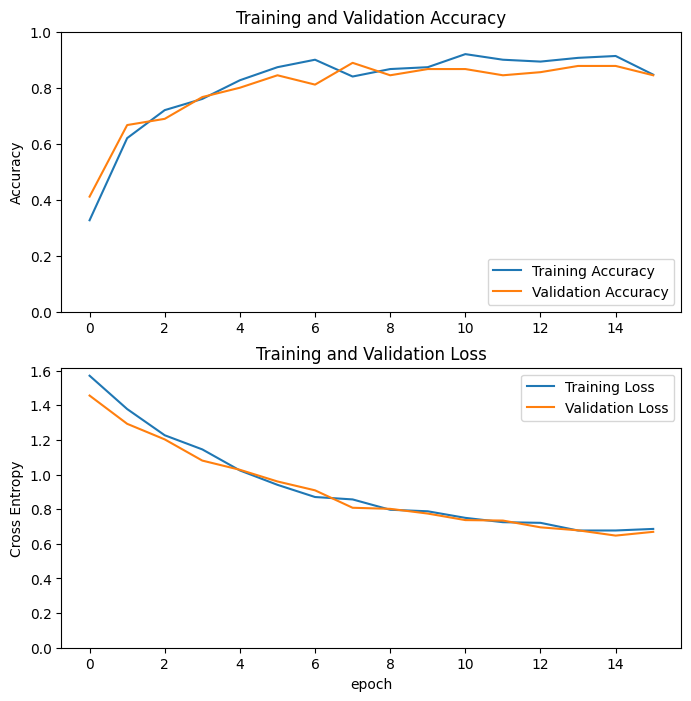

Corn



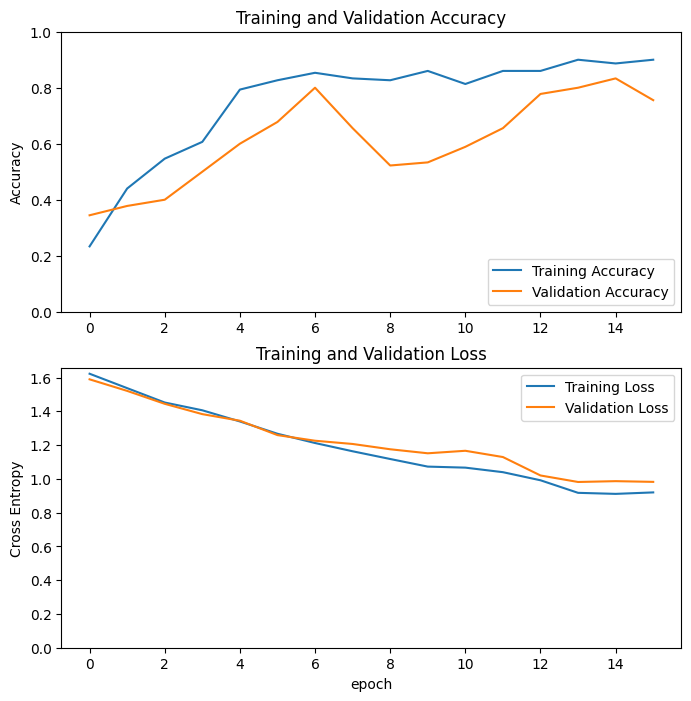

Grape



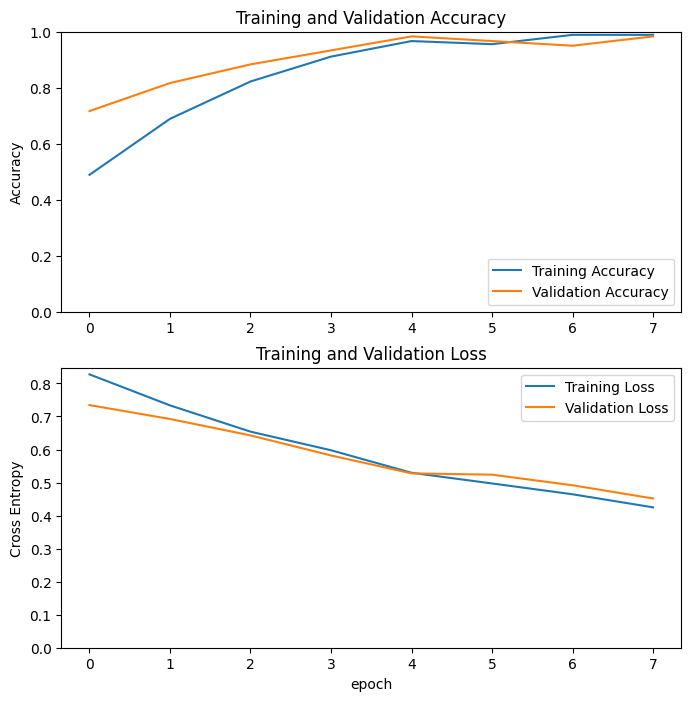

Peach



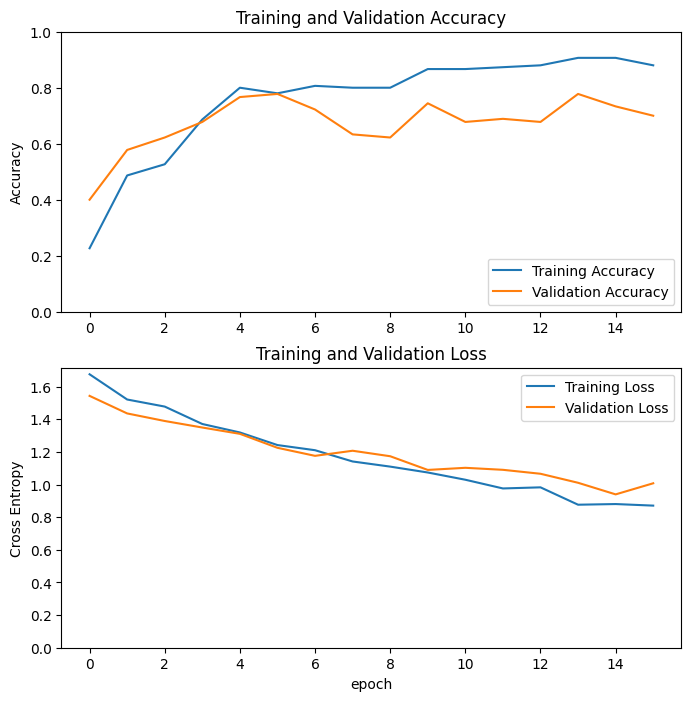

Apple



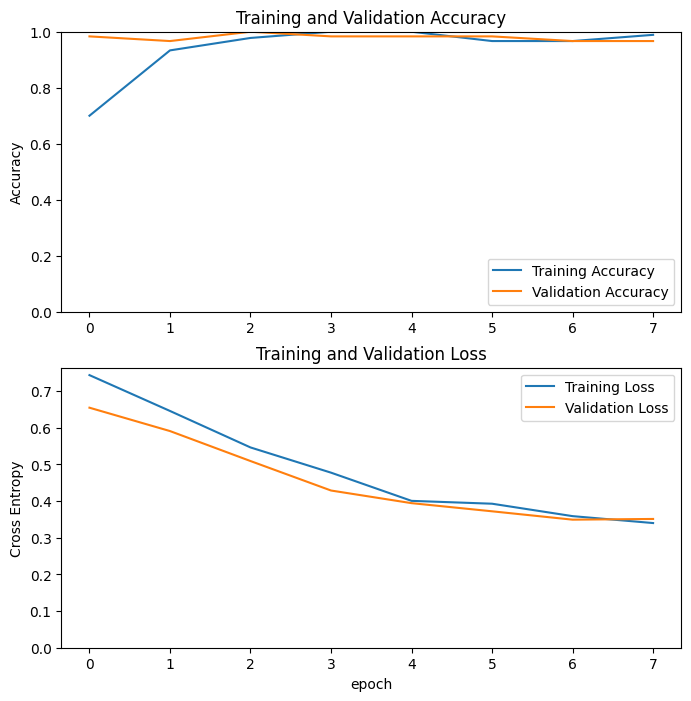

Cherry



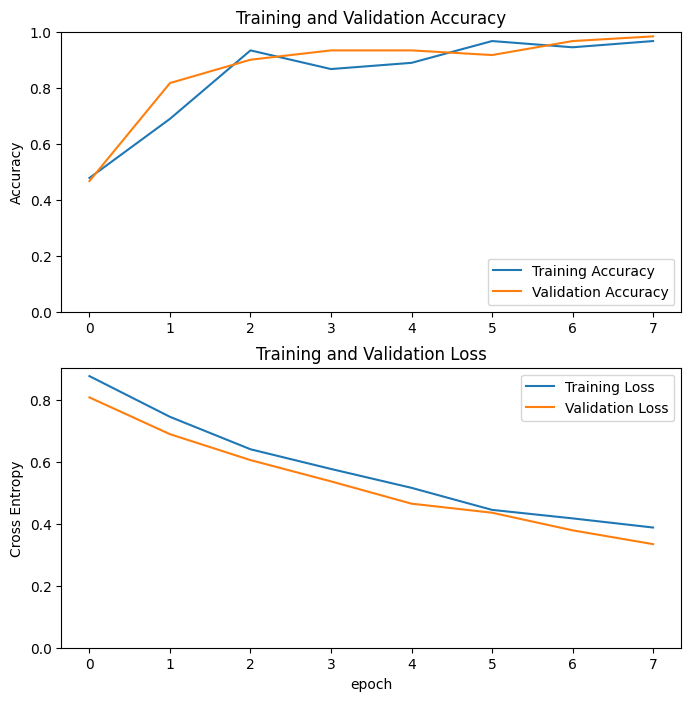

Strawberry



In [28]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([0,1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,max(plt.ylim())])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

for disease, model in disease_models.items():
  history = model['train_history']
  if len(history.history['accuracy']) > 1:
    plot_history(model['train_history'])
    print(f"{disease}\n")


## Connect pipeline

In [29]:
print(disease_models.keys())

dict_keys(['Raspberry', 'Pepper', 'Potato', 'Tomato', 'Orange', 'Corn', 'Grape', 'Soybean', 'Peach', 'Blueberry', 'Apple', 'Squash', 'Cherry', 'Strawberry'])


In [30]:
import cv2

def predict(source):
  yolo_pred = yolo_model.predict(
    source=source,
    conf=0.25
  )

  clear_output()
  if os.path.isdir(source):
    images_names = sorted(list(os.listdir(source)))
    images_path = [os.path.join(source, img) for img in images_names]
  else:
    images_path = [source]
  
  images = [cv2.imread(img) for img in images_path]
  images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]
  predictions_class = []
  leafs_sets = []
  for pred, img in zip(yolo_pred, images):
    cls = pred.boxes.cls.cpu().numpy().astype(int)
    cls = [yolo_names[cl] for cl in cls]
    predictions_class.append(cls)

    if not cls: # if no leaf detected in image
      leafs_sets.append(np.array([])) # add a empty "image"
      continue
    
    bounding_boxes = [box.xyxy.cpu().numpy().astype(int)[0] for box in pred.boxes]
    cropped_leaf_imgs = [img[bb[1]:bb[3], bb[0]:bb[2]] for bb in bounding_boxes]
    resized_leafs = [cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA) for img in cropped_leaf_imgs]
    
    leafs_sets.append(np.array(resized_leafs))
  
  leafs_sets = np.array(leafs_sets)
  predictions_diseases = []
  for leafs, cls in zip(leafs_sets, predictions_class):

    if leafs.shape[0] > 0:
      for leaf, cl in zip(leafs, cls):
        # leaf = [image_standardization(l) for l in leaf]
        leaf = np.array([leaf])
        model = disease_models[cl]['model']
        pred = model.predict(leaf)

        diseases = [disease_models[cl]['class_names'][np.argmax(p)] for p in pred]
          
        
        predictions_diseases.append(diseases)
    else:
      print("No leaf detected")
      predictions_diseases.append([""])
  

  clear_output()
  return list(zip(images_path, predictions_class, predictions_diseases))


In [31]:
def prompt_predict(pred):
  for path, cls, diseases in pred:
    #plt.imshow(cv2.imread(path))
    #plt.axis('off')
    #plt.show()
    print(f'path: {path}\npred: {cls}, {diseases}\n')

def pred_accuracy(pred):

  def norm_str(string):
    return ''.join(e for e in string if e.isalnum() and not e.isnumeric()).lower()

  count_cls = 0
  count_disease = 0
  count = 0
  for path, cls, diseases in pred:
    if cls:
      cls = norm_str(cls[0])
      diseases = norm_str(diseases[0])
      path = norm_str(path)
      if cls in path:
        count_cls+=1
      if diseases in path:
        count_disease+=1
      if cls in path and diseases in path:
        count+=1
  m = len(pred)
  return count/m, count_cls/m, count_disease/m

In [32]:
pred = predict('/content/datasets/val/images')
total_acc, cls_acc, disease_acc = pred_accuracy(pred)

print(f"Total accuracy(leaf and disease corrects): {total_acc}\nClass accuracy: {cls_acc}\nDisease accuracy: {disease_acc}")

Total accuracy(leaf and disease corrects): 0.875
Class accuracy: 0.875
Disease accuracy: 0.875


In [33]:
total_acc, cls_acc, disease_acc = pred_accuracy(predict('/content/datasets/train/images'))

print(f"Total accuracy(leaf and disease corrects): {total_acc}\nClass accuracy: {cls_acc}\nDisease accuracy: {disease_acc}")

Total accuracy(leaf and disease corrects): 0.8133971291866029
Class accuracy: 0.9665071770334929
Disease accuracy: 0.8133971291866029
